In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Bert_Lime/SNLI/

/content/drive/.shortcut-targets-by-id/1CLIDh5rSBKopppgMh7zb8C3_AWNoz6B8/Bert_Lime/SNLI


In [ ]:
!pip install transformers
!pip install seqeval datasets allennlp
!pip install flax
!pip install sentencepiece
!pip install nltk
!pip install gensim

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_datasets.text import Snli
import os

In [ ]:
from __future__ import division

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()

        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.
        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size
        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor
        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
ac_dict = {"neutral" : 1, "entailment" : 0, "contradiction" : 2}

In [ ]:
import os
from operator import itemgetter    
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

# from keras import models, regularizers, layers, optimizers, losses, metrics
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras.utils import to_categorical
# from keras.layers import LayerNormalization
import tensorflow as tf
from tensorflow.keras.datasets import imdb

In [ ]:
import torch

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
print(len(ac_dict))

3


In [ ]:
model_version = 'allenai/longformer-base-4096'
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch

In [ ]:
from huggingface_hub import create_repo

In [ ]:

from transformers import LongformerTokenizer, LongformerModel
tokenizer = LongformerTokenizer.from_pretrained(model_version,
                                          bos_token = "[CLS]",
                                          eos_token = "[SEP]")
transformer_model = LongformerModel.from_pretrained(model_version, output_attentions = True).to(device)
linear_layer = nn.Linear(transformer_model.config.hidden_size,
                         len(ac_dict)).to(device)
cross_entropy_layer = nn.CrossEntropyLoss()
normalizing_layer = Sparsemax(dim = 1)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# # del transformer_model
# del optimizer

In [ ]:
print(transformer_model.config.hidden_size)

768


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
from tqdm import tqdm

In [ ]:
from typing import List, Tuple

In [ ]:
def pad_batch(elems: List[List[int]], pad_token_id: int) -> List[List[int]]:
    """Pads all lists in elems to the maximum list length of any list in 
    elems. Pads with pad_token_id.
    """
    max_len = max([len(elem) for elem in elems])
    return [elem+[pad_token_id]*(max_len-len(elem)) for elem in elems]

def load_dataset(tokenizer):
  train, test = tfds.as_numpy(tfds.load("Snli", split=['train', 'test']))

  parts = []

  new_train_data = []
  train_labels = []
  cnt = 0
  for tokenized_text in tqdm(train):
    cnt += 1
    if(cnt >= 10000):
      break
    decoded_sent = "[CLS] " +  str(tokenized_text["hypothesis"])[2:-1] + " [SEP] " + str(tokenized_text["premise"])[2:-1] + " [SEP]"
    # print(decoded_sent)
    new_encoded_text = tokenizer.encode(decoded_sent)
    if(tokenized_text["label"] < 0 or tokenized_text["label"] > 2):
      continue
    new_train_data.append(new_encoded_text)
    train_labels.append(tokenized_text["label"])
  
  new_test_data = []
  test_labels = []
  for tokenized_text in tqdm(test):
    decoded_sent = "[CLS] " +  str(tokenized_text["hypothesis"])[2:-1] + " [SEP] " + str(tokenized_text["premise"])[2:-1] + " [SEP]"
    # print(decoded_sent)
    new_encoded_text = tokenizer.encode(decoded_sent)
    if(tokenized_text["label"] < 0 or tokenized_text["label"] > 2):
      continue
    new_test_data.append(new_encoded_text)
    test_labels.append(tokenized_text["label"])


  return (new_train_data, train_labels), (new_test_data, test_labels)

def generator(dataset_data, dataset_label, max_len = 512, batch_size = 16):
  i = 0
  tokenized_threads, labels = [], []
  while i<len(dataset_data):
    tokenized_threads.append(dataset_data[i][:max_len])
    labels.append(dataset_label[i])
    i += 1
        
    if i%batch_size==0:
      yield (pad_batch(tokenized_threads, tokenizer.pad_token_id), 
                  labels)
      tokenized_threads, labels = [], []

In [ ]:
from itertools import chain

import torch.optim as optim

optimizer = optim.Adam(params = chain(transformer_model.parameters(),
                                      linear_layer.parameters()),
                       lr = 2e-5)

In [ ]:
def train(dataset_data, dataset_label, batch_size):
    global values_weight, values_bias;
    accumulate_over = 32
    
    optimizer.zero_grad()
    print("Training")
    for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label,  batch_size = batch_size)):
        
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        labels = torch.tensor(labels, device=device, dtype=torch.long)


        loss = compute((tokenized_threads, 
                        labels,), False)

        print("\rLoss: ", loss.item(), end = " ")

        loss.backward()

        if i%accumulate_over==accumulate_over-1:
            optimizer.step()
            optimizer.zero_grad()
    print()
    optimizer.step()

In [ ]:
from datasets import load_metric
metric1 = load_metric("accuracy")
metric3 = load_metric("precision", average = "micro")
metric2 = load_metric("f1", average = "micro")
metric4 = load_metric("recall", average = "micro")
metric5 = load_metric("precision", average = "macro")
metric6 = load_metric("f1", average = "macro")
metric7 = load_metric("recall", average = "macro")


In [ ]:
def evaluate(dataset_data, dataset_label, BATCH_SIZE):
    
    int_to_labels = {v:k for k, v in ac_dict.items()}
    print('Evaluation')
    
    with torch.no_grad():
        for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE)):
            # print(comp_type_labels)
            #Cast to PyTorch tensor
            tokenized_threads = torch.tensor(tokenized_threads, device=device)
            labels = torch.tensor(labels, device=device)

            preds = compute((tokenized_threads, 
                            labels,), pred=True)
            loss = compute((tokenized_threads, labels,), pred = False)
            
            metric1.add_batch(predictions=preds, 
                            references=labels,)
                            #tokenized_threads=tokenized_threads.cpu().tolist())
            metric2.add_batch(predictions=preds, 
                            references=labels,)
            metric3.add_batch(predictions=preds, 
                            references=labels,)
            metric4.add_batch(predictions=preds, 
                            references=labels,)
            metric5.add_batch(predictions=preds, 
                            references=labels,)
            metric6.add_batch(predictions=preds, 
                            references=labels,)
            metric7.add_batch(predictions=preds, 
                            references=labels,)
            
            print("\rLoss: ", loss.item(), end = " ")
    print()
    print(metric1.compute())
    print("Micro")
    print(metric2.compute(average = "micro"))
    print(metric3.compute(average = "micro"))
    print(metric4.compute(average = "micro"))
    print("Macro")
    print(metric5.compute(average = "macro"))
    print(metric6.compute(average = "macro"))
    print(metric7.compute(average = "macro"))

In [ ]:

(train_dataset_data, train_dataset_label), (test_dataset_data, test_dataset_label) = load_dataset(tokenizer)

INFO:absl:Load dataset info from /root/tensorflow_datasets/snli/1.1.0
INFO:absl:Reusing dataset snli (/root/tensorflow_datasets/snli/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from /root/tensorflow_datasets/snli/1.1.0
9999it [00:07, 1333.94it/s]
10000it [00:10, 975.99it/s]


In [ ]:
transformer_model.resize_token_embeddings(len(tokenizer))

Embedding(50267, 768)

In [ ]:
def compute(batch: Tuple[torch.Tensor, torch.Tensor], pred: bool=True):
    """
    Args:
        batch:  A tuple having tokenized thread of shape [batch_size, seq_len],
                component type labels of shape [batch_size, seq_len], and a global
                attention mask for Longformer, of the same shape.
        
        
        cross_entropy:  This argument will only be used if preds=False, i.e., if 
                        loss is being calculated. If True, then cross entropy loss
                        will also be added to the output loss.
    
    Returns:
        Either the predicted sequences with their scores for each element in the batch
        (if preds is True), or the loss value summed over all elements of the batch
        (if preds is False).
    """
    tokenized_threads, labels = batch
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, torch.tensor(1).to(device), torch.tensor(0).to(device))
    x = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)
#     print(tokenized_threads.shape)
#     print(x[0].last_hidden_state, x[1].shape, len(x[2]))
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[0][:, 0, :])

    logits = normalizing_layer(logits)
    if(pred):
      return torch.argmax(logits, dim = 1)

    ce_loss = cross_entropy_layer(logits, labels)

    return ce_loss

In [ ]:
import numpy as np
def shuffle(data, labels):
  idx = np.random.permutation(len(data))
  x,y = np.array(data)[idx], np.array(labels)[idx]
  return x.tolist(), y.tolist()

In [ ]:
BATCH_SIZE = 4

In [ ]:
print(tokenizer.decode([101]))

 like


In [ ]:
print(device)

cuda:0


In [ ]:
import pickle


In [ ]:
linear_path = "Model_longformer/linear_layer.pt"
cross_path = "Model_longformer/cross_entropy_layer.pt"
tokenizer_path = "Model_longformer/tokenizer_pre.pkl"
transformer_path = "Model_longformer/transformer_layer.pt"
offset_path = "Model_longformer/offset.pkl"

In [ ]:
train_dataset_data, train_dataset_label = shuffle(train_dataset_data, train_dataset_label)
test_dataset_data, test_dataset_label = shuffle(test_dataset_data, test_dataset_label)
X_train, Y_train = train_dataset_data, train_dataset_label
X_test, Y_test = test_dataset_data, test_dataset_label

In [ ]:
offset = 0
with open(offset_path, "wb") as f:
    pickle.dump(offset, f)
with open(offset_path, "rb") as f:
    offset = pickle.load(f)


In [ ]:
n_epochs = 2
step = 16000
with open(offset_path, "rb") as f:
      offset = pickle.load(f)

for epoch in range(n_epochs):
    print(f"------------EPOCH {epoch+1}---------------")
    #loading data
    # with open(offset_path, "rb") as f:
    #   offset = pickle.load(f)
    linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
    cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
    transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
    with open(tokenizer_path, "rb") as f:
      tokenizer = pickle.load(f)

    while(offset <= len(X_train)):

      #training and evaluating 
      print("Train")
      train(X_train[offset: offset + step], Y_train[offset: offset + step], BATCH_SIZE)
      torch.save(linear_layer.state_dict(), linear_path)
      torch.save(cross_entropy_layer.state_dict(), cross_path)
      torch.save(transformer_model.state_dict(), transformer_path)
      with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)

      offset += step
      #saving offset
      with open(offset_path, "wb") as f:
        pickle.dump(offset, f)
        
      print("Test accuracy")
      evaluate(X_test, Y_test, BATCH_SIZE)


------------EPOCH 1---------------
Train
Training
Loss:  0.8808967471122742 
Test accuracy
Evaluation
Loss:  0.5514447689056396 
{'accuracy': 0.7827768729641694}
Micro
{'f1': 0.7827768729641693}
{'precision': 0.7827768729641694}
{'recall': 0.7827768729641694}
Macro
{'precision': 0.80260102554101}
{'f1': 0.7845666755750983}
{'recall': 0.7826597895748689}
------------EPOCH 2---------------


In [ ]:
print(offset)

16000


In [ ]:
print(len(test_dataset_label))

9824


In [ ]:
print(test_dataset_label)

[1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2, 0, 1, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1, 0, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 0, 2, 2, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 0, 0, 0, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 2, 0, 2, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 0, 2, 1, 1, 2, 1, 2, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 0, 2, 2, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 2, 1, 1, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1, 1, 

In [ ]:
torch.save(linear_layer.state_dict(), linear_path)
torch.save(cross_entropy_layer.state_dict(), cross_path)
torch.save(transformer_model.state_dict(), transformer_path)
with open(tokenizer_path, "wb") as f:
  pickle.dump(tokenizer, f)

In [ ]:
linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
with open(tokenizer_path, "rb") as f:
  tokenizer = pickle.load(f)

In [ ]:
from multiprocessing import Process, Manager, Array
manager = Manager()

In [ ]:
graph_attention = []
for i in range(12):
  graph_attention.append({})
mapping_ind = {}
rev_mapping_ind = {}

In [ ]:
cnt = 0
threshold = 0.01

In [ ]:
import multiprocessing as mp
from tqdm import tqdm

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:


my_arr = [1 for i in range(100)]

def func(i, j , k):
    global my_arr
    my_arr[i] = 3
    

indexes = [(i, i, i) for i in range(12)]
pool = mp.Pool(min(12, mp.cpu_count()))
pool.starmap(func, indexes)
pool.close()

In [ ]:
type(mp.cpu_count())

int

In [ ]:
temp_attention = []
def init_arr(arr):
    globals()['arr'] = arr
from copy import deepcopy
def store_attention(lay, j, tokens):
        
    global mapping_ind, graph_attention, temp_attention;
    maximum_attention = np.max(temp_attention)
    weights = temp_attention[j, lay, :, :]
    temp_dict = {}
    for ind_1 in range(len(tokens)):
        for ind_2 in range(len(tokens)):
            if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                continue
            node_1 = mapping_ind[tokens[ind_1]]
            node_2 = mapping_ind[tokens[ind_2]]
            weight = weights[ind_1, ind_2]

            if(weight < threshold*maximum_attention):
                continue
            if(node_1 not in temp_dict):
                temp_dict[node_1] = {}
            
            if(node_2  not in temp_dict[node_1]):
                temp_dict[node_1][node_2] = (weight, 1)
            else:
                temp_dict[node_1][node_2] = (weight*temp_dict[node_1][node_2][1]/(temp_dict[node_1][node_2][1] + 1), temp_dict[node_1][node_2][1] + 1)
    graph_attention[lay] = deepcopy(temp_dict)
#     print(graph_attention)
def attention_graph(dataset_data, dataset_label, BATCH_SIZE):
    
    
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i, (tokenized_threads, labels) in tqdm(enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE))):
    
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        temp_attention = attention[:, :, :, :]
        maximum_attention = np.max(attention)
        for j, tokenized_thread in enumerate(tokenized_threads):
            tokens = tokenizer.convert_ids_to_tokens(tokenized_thread) 
            # print(len(tokens))
            # print(tokenized_thread.shape)
            for tok in tokens:
                if(tok not in mapping_ind):
                    mapping_ind[tok] = cnt;
                    cnt += 1
            
    for i, (tokenized_threads, labels) in tqdm(enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE))):
    
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        temp_attention = attention[:, :, :, :]
        maximum_attention = np.max(attention)
        for j, tokenized_thread in enumerate(tokenized_threads):
            tokens = tokenizer.convert_ids_to_tokens(tokenized_thread) 

#             params = [(i1, j, tokens) for i1 in range(12)]
#             pool = mp.Pool(min(12, mp.cpu_count()))
#             pool.starmap(store_attention, params)
#             pool.close()
            for lay in range(12):
                weights = attention[j, lay, :, :]
                for ind_1 in range(len(tokens)):
                    for ind_2 in range(len(tokens)):
                        if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                            continue

                        node_1 = mapping_ind[tokens[ind_1]]
                        node_2 = mapping_ind[tokens[ind_2]]
                        weight = weights[ind_1, ind_2]
                        if(weight < threshold*maximum_attention):
                            continue
                        if(node_1 not in graph_attention[lay]):
                            graph_attention[lay][node_1] = {}
                        if(node_2  not in graph_attention[lay][node_1]):
                            graph_attention[lay][node_1][node_2] = (weight, 1)
                        else:
                            graph_attention[lay][node_1][node_2] = ((weight + (graph_attention[lay][node_1][node_2][0])*graph_attention[lay][node_1][node_2][1])/(graph_attention[lay][node_1][node_2][1] + 1), graph_attention[lay][node_1][node_2][1] + 1)
#         print(cnt, cnt**2)              


In [ ]:
def extract_data(dataset_data, dataset_label, BATCH_SIZE):
    example = [[], [], []]
    for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE)):
        for j in range(BATCH_SIZE):
            if(len(example[0]) < 5 or len(example[1]) < 5 or len(example[2]) < 5):
                example[labels[j]].append((tokenizer.convert_ids_to_tokens(tokenized_threads[j]), tokenized_threads[j]))
            else:
                break
    return example

In [ ]:
text = extract_data(test_dataset_data, test_dataset_label, BATCH_SIZE)

In [ ]:
import random

In [ ]:
def find_degree(nodes, graph):
    out_degree = {}
    in_degree = {}
    for node_1 in graph:
        for node_2 in graph[node_1]:
            if(node_1 not in out_degree):
                out_degree[node_1] = 0
            if(node_2 not in in_degree):
                in_degree[node_2] = 0;
            in_degree[node_2] += 1;
            out_degree[node_1] += 1;
    ret_out = [out_degree[i] for i in nodes]
    ret_in = [in_degree[i] for i in nodes]
    return ret_out, ret_in
def find_topk_tokens(graph, k):
    attention = {}
    attention_inward = {}
    for node_1 in graph:
        if(node_1 not in attention):
            attention[node_1] = (0, 0)
        for node_2 in graph[node_1]:
            
            if(node_2 not in attention_inward):
                attention_inward[node_2] = (0, 0)
            attention[node_1] = ((graph[node_1][node_2][0] + (attention[node_1][0])*attention[node_1][1])/(attention[node_1][1] + 1), attention[node_1][1] + 1)
            attention_inward[node_2] = ((graph[node_1][node_2][0] + (attention_inward[node_2][0])*attention_inward[node_2][1])/(attention_inward[node_2][1] + 1), attention_inward[node_2][1] + 1)
    out_max = [i[0] for i in find_maxk(attention, k)]
    in_max = [i[0] for i in find_maxk(attention_inward, k)]
    return in_max, out_max, [i[1] for i in find_maxk(attention_inward, k)], [i[1] for i in find_maxk(attention, k)], find_mink(attention, k)[0][1], find_mink(attention_inward, k)[0][1]
def find_mink(attention, k):
    ret = []
    for i in attention:
        if(i == mapping_ind["[CLS]"] or i == mapping_ind["[SEP]"]):
            continue
        ret.append((i, attention[i][0]))
    ret.sort(key = lambda x: x[1])
    return ret[:k]
def find_maxk(attention, k):
    ret = []
    for i in attention:
        if(i == mapping_ind["[CLS]"] or i == mapping_ind["[SEP]"]):
            continue
        ret.append((i, attention[i][0]))
    ret.sort(key = lambda x: x[1])
    ret.reverse()
    # print(ret)
    return ret[:k]

In [ ]:
def remove_pad(given_s):
    l = given_s.split()
    ret = []
    for i in l:
        if(i != "[PAD]"):
            ret.append(i)
    return " ".join(ret)

In [ ]:
def replacing(tok_mapping, tokenized_thread, tokens):
    ret_tokenized_thread = tokenized_thread.clone()
    ind = []
    for i in range(len(tokens)):
        if(mapping_ind[tokens[i]] in tok_mapping):
            ret_tokenized_thread[0, i] = tokenizer.encode(tok_mapping[mapping_ind[tokens[i]]])[1];
            ind.append(i)
    return ret_tokenized_thread, ind

In [ ]:
vocab_dict = tokenizer.get_vocab()

In [ ]:

vocab = []
for i in vocab_dict:
  if(i not in ["[CLS]", '[PAD]', '[SEP]']):
    vocab.append(i)



In [ ]:
import random
def create_mapping(tok, ind):
    ret_dict = {}
    for k, i in enumerate(tok):
        if((k + i) < len(vocab)):
            ret_dict[i] = vocab[k + ind]
        else:
            ret_dict[i] = random.choice(vocab)
        ret_dict[i] = random.choice(vocab)
    return ret_dict

In [ ]:
def get_embedding(ind, tokenized):
    pad_mask = torch.where(tokenized!=tokenizer.pad_token_id, 1, 0)
    embedding = transformer_model(input_ids=tokenized,attention_mask=pad_mask,).last_hidden_state
    ret_embedding = []
    for i in ind:
        ret_embedding.append(embedding[:, i, :].reshape((embedding.shape[2])))
    return ret_embedding

In [ ]:
replacement = 100
trials = 3
trial_candidate = 5
select_max = 5

In [ ]:
print(len(text[1]))

15


In [ ]:
import matplotlib.pyplot as plt
from scipy import spatial
text[0] = text[0][:3]
text[1] = text[1][:3]
text[2] = text[2][:3]

In [ ]:
def predict_proba(tokenized_threads):
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,attention_mask=pad_mask,).last_hidden_state[:, 0, :])
    logits = torch.exp(logits)
    z = torch.sum(logits)
    logits = torch.divide(logits, z)
    return logits
def mask_out_top5(text_lab, label, label_ind, flag):
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i1, (tokens, tokenized_threads) in enumerate(text_lab):
        print("\n\n\n")
        print("###### Example :", str(i1), "label", label, "########")
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device).reshape((1, len(tokenized_threads)))
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
        
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        graph = dict()
        for tok in tokens:
            if(tok not in mapping_ind):
                mapping_ind[tok] = cnt;
                cnt += 1

        for lay in range(12):
            weights = attention[0, lay, :, :]

            for ind_1 in range(len(tokens)):
                for ind_2 in range(len(tokens)):
                    if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                        continue
                    node_1 = mapping_ind[tokens[ind_1]]
                    node_2 = mapping_ind[tokens[ind_2]]
                    rev_mapping_ind[node_1] = tokens[ind_1]
                    rev_mapping_ind[node_2] = tokens[ind_2]
                    weight = weights[ind_1, ind_2]
                    if(node_1 not in graph):
                        graph[node_1] = {}
                    if(node_2  not in graph[node_1]):
                        graph[node_1][node_2] = (weight, 1)
                    else:
                        graph[node_1][node_2] = ((weight + (graph[node_1][node_2][0])*graph[node_1][node_2][1])/(graph[node_1][node_2][1] + 1), graph[node_1][node_2][1] + 1)

        topk_in, topk_out, topk_in_attention, topk_out_attention, topk_in_min, topk_out_min  = find_topk_tokens(graph, select_max)

        
        candidate = random.sample(topk_in, trial_candidate)
        for j in range(trials):
            random.shuffle(vocab)
            print([ rev_mapping_ind[z] for z in candidate], "\n")
            in_logits_l2_norm = []
            for l in tqdm(range(0, min(len(vocab), 1000), select_max)):
                top5_in_mapping = create_mapping(candidate, l)

                example_in, ind_in = replacing(top5_in_mapping, tokenized_threads, tokens)

                actual_in = get_embedding(ind_in, tokenized_threads)
                replaced_in = get_embedding(ind_in, example_in)

                if(len(ind_in) >= 1):
                    final_actual_in = torch.divide(sum(actual_in),len(actual_in)).cpu().detach().numpy()
                    final_replaced_in = torch.divide(sum(replaced_in) , len(replaced_in)).cpu().detach().numpy()
                else:
                    continue
                if(predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind] < 0.5):
                    continue
                subtract_in = np.subtract(final_actual_in, final_replaced_in)
                if(flag == "L2"):
                    in_logits_l2_norm.append((np.linalg.norm(subtract_in), predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind]))
                elif(flag == "Cosine"):
                    in_logits_l2_norm.append((spatial.distance.cosine(final_actual_in, final_replaced_in), predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind]))
                    
                    
            in_logits_l2_norm.sort(key = lambda x : x[0])
            

            plt.scatter([i[0] for i in in_logits_l2_norm],[i[1] for i in in_logits_l2_norm])
        print("| Min:", topk_in_min)
        for i in range(len(topk_in)):
            print("Token:", rev_mapping_ind[topk_in[i]], "| attention:", topk_in_attention[i])
        plt.title('Example ' + str(i) + ' in')
        plt.xlabel(flag + ' norm')
        plt.ylabel('probability of '+ label )
        plt.show()
        plt.clf()
        
        candidate = random.sample(topk_out, trial_candidate)
        for j in range(trials):

            random.shuffle(vocab)
            print([ rev_mapping_ind[z] for z in candidate], "\n")
            out_logits_l2_norm = []
            for l in tqdm(range(0, min(len(vocab), 1000), select_max)):
                top5_out_mapping = create_mapping([j], l)

                
                
                example_out, ind_out = replacing(top5_out_mapping, tokenized_threads, tokens)

                actual_out = get_embedding(ind_out, tokenized_threads)
                replaced_out = get_embedding(ind_out, example_out)
#                 print(sum(actual_out))
                if(len(ind_out) >= 1):
                    final_actual_out = torch.divide(sum(actual_out) , len(actual_out)).cpu().detach().numpy()
                    final_replaced_out = torch.divide(sum(replaced_out) , len(replaced_out)).cpu().detach().numpy()
                else:
                    continue
                if(predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind] < 0.50):
                    continue    
                subtract_out = np.subtract(final_actual_out, final_replaced_out)
                if(flag == "L2"):
                    out_logits_l2_norm.append((np.linalg.norm(subtract_out), predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind]))
                elif(flag == "Cosine"):
                    out_logits_l2_norm.append((spatial.distance.cosine(final_actual_out, final_replaced_out), predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind]))
                    
            out_logits_l2_norm.sort(key = lambda x : x[0])
            
            plt.scatter([i[0] for i in out_logits_l2_norm],[i[1] for i in out_logits_l2_norm])

        print("| Min:", topk_out_min)
        for i in range(len(topk_out)):
            print("Token:", rev_mapping_ind[topk_out[i]], "| attention:", topk_out_attention[i])
        plt.title('Example ' + str(i) + ' out')
        plt.xlabel(flag + ' norm')
        plt.ylabel('probability of ' + label )
        plt.show()
        plt.clf()





###### Example : 0 label neutral ########
['Ġsculpture', 'Ġhair', 'Ġmaking', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.57it/s]


['Ġsculpture', 'Ġhair', 'Ġmaking', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.52it/s]


['Ġsculpture', 'Ġhair', 'Ġmaking', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġsculpture | attention: 0.0
Token: Ġmaking | attention: 0.0
Token: Ġhair | attention: 0.0


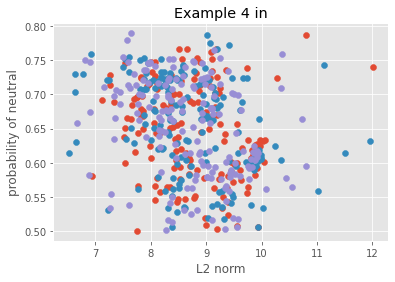

['<pad>', 'Ġhair', 'Ġmaking', 'Ġsculpture', '</s>'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['<pad>', 'Ġhair', 'Ġmaking', 'Ġsculpture', '</s>'] 



100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


['<pad>', 'Ġhair', 'Ġmaking', 'Ġsculpture', '</s>'] 



100%|██████████| 200/200 [00:58<00:00,  3.44it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġsculpture | attention: 0.0
Token: Ġmaking | attention: 0.0
Token: Ġhair | attention: 0.0


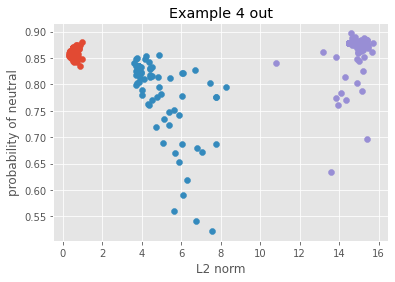





###### Example : 1 label neutral ########
['Ġsomething', 'Ġat', '<pad>', 'Ġupwards', '</s>'] 



100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


['Ġsomething', 'Ġat', '<pad>', 'Ġupwards', '</s>'] 



100%|██████████| 200/200 [00:59<00:00,  3.35it/s]


['Ġsomething', 'Ġat', '<pad>', 'Ġupwards', '</s>'] 



100%|██████████| 200/200 [00:59<00:00,  3.34it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġsomething | attention: 0.0
Token: Ġat | attention: 0.0
Token: Ġupwards | attention: 0.0


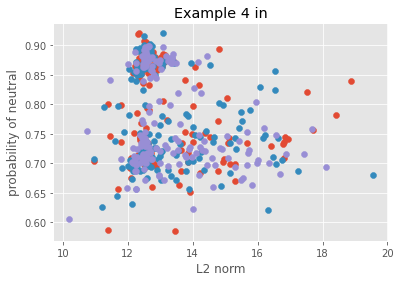

['<pad>', 'Ġsomething', 'Ġupwards', '</s>', 'Ġat'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['<pad>', 'Ġsomething', 'Ġupwards', '</s>', 'Ġat'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['<pad>', 'Ġsomething', 'Ġupwards', '</s>', 'Ġat'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġsomething | attention: 0.0
Token: Ġat | attention: 0.0
Token: Ġupwards | attention: 0.0


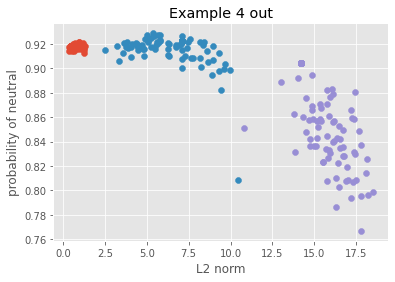





###### Example : 2 label neutral ########
['ĠStorm', '<pad>', '</s>', 'Ġpicture', 'Ġwith'] 



100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


['ĠStorm', '<pad>', '</s>', 'Ġpicture', 'Ġwith'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


['ĠStorm', '<pad>', '</s>', 'Ġpicture', 'Ġwith'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: ĠStorm | attention: 0.0
Token: Ġwith | attention: 0.0
Token: Ġpicture | attention: 0.0


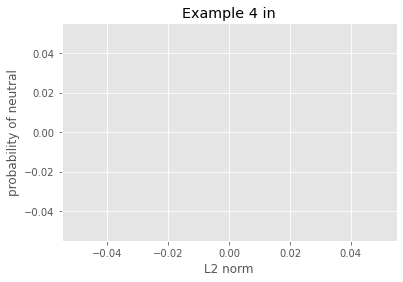

['Ġpicture', 'Ġwith', '</s>', '<pad>', 'ĠStorm'] 



100%|██████████| 200/200 [00:58<00:00,  3.42it/s]


['Ġpicture', 'Ġwith', '</s>', '<pad>', 'ĠStorm'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['Ġpicture', 'Ġwith', '</s>', '<pad>', 'ĠStorm'] 



100%|██████████| 200/200 [00:29<00:00,  6.79it/s]


| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: ĠStorm | attention: 0.0
Token: Ġwith | attention: 0.0
Token: Ġpicture | attention: 0.0


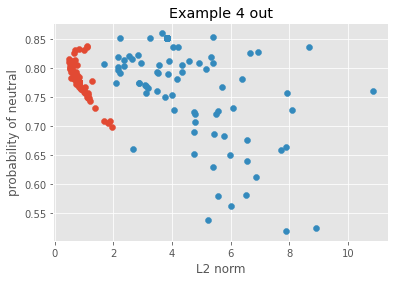

<Figure size 432x288 with 0 Axes>

In [ ]:

mask_out_top5(text[0], "neutral", 0, "L2")





###### Example : 0 label entailment ########
['</s>', 'Ġstreet', '<pad>', 'Ġwork', 'Ġopen'] 



100%|██████████| 200/200 [00:58<00:00,  3.42it/s]


['</s>', 'Ġstreet', '<pad>', 'Ġwork', 'Ġopen'] 



100%|██████████| 200/200 [00:58<00:00,  3.44it/s]


['</s>', 'Ġstreet', '<pad>', 'Ġwork', 'Ġopen'] 



100%|██████████| 200/200 [00:58<00:00,  3.42it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġwork | attention: 0.0
Token: Ġstreet | attention: 0.0
Token: Ġopen | attention: 0.0


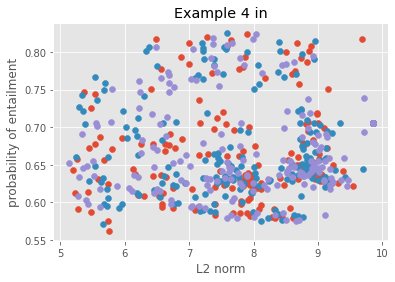

['<pad>', 'Ġstreet', '</s>', 'Ġopen', 'Ġwork'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['<pad>', 'Ġstreet', '</s>', 'Ġopen', 'Ġwork'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['<pad>', 'Ġstreet', '</s>', 'Ġopen', 'Ġwork'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġwork | attention: 0.0
Token: Ġstreet | attention: 0.0
Token: Ġopen | attention: 0.0


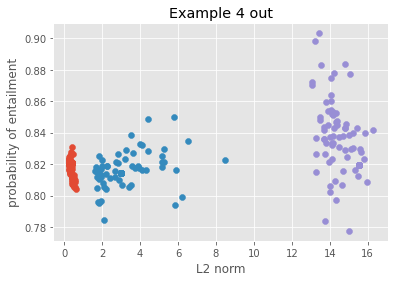





###### Example : 1 label entailment ########
['</s>', 'Ġguitar', 'Ġacoustic', 'Ġan', '<pad>'] 



100%|██████████| 200/200 [00:50<00:00,  4.00it/s]


['</s>', 'Ġguitar', 'Ġacoustic', 'Ġan', '<pad>'] 



100%|██████████| 200/200 [00:49<00:00,  4.07it/s]


['</s>', 'Ġguitar', 'Ġacoustic', 'Ġan', '<pad>'] 



100%|██████████| 200/200 [00:50<00:00,  3.98it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġguitar | attention: 0.0
Token: Ġacoustic | attention: 0.0
Token: Ġan | attention: 0.0


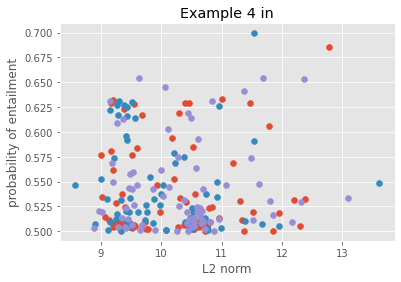

['Ġguitar', '</s>', 'Ġan', 'Ġacoustic', '<pad>'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['Ġguitar', '</s>', 'Ġan', 'Ġacoustic', '<pad>'] 



100%|██████████| 200/200 [00:47<00:00,  4.23it/s]


['Ġguitar', '</s>', 'Ġan', 'Ġacoustic', '<pad>'] 



100%|██████████| 200/200 [00:29<00:00,  6.81it/s]


| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġguitar | attention: 0.0
Token: Ġacoustic | attention: 0.0
Token: Ġan | attention: 0.0


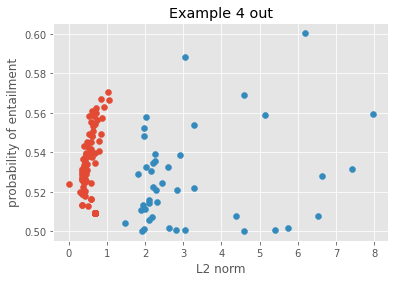





###### Example : 2 label entailment ########
['Ġa', '</s>', 'Ġroad', '<pad>', 'ĠItaly'] 



100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


['Ġa', '</s>', 'Ġroad', '<pad>', 'ĠItaly'] 



100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


['Ġa', '</s>', 'Ġroad', '<pad>', 'ĠItaly'] 



100%|██████████| 200/200 [00:57<00:00,  3.46it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: ĠItaly | attention: 0.0
Token: Ġroad | attention: 0.0
Token: Ġa | attention: 0.0


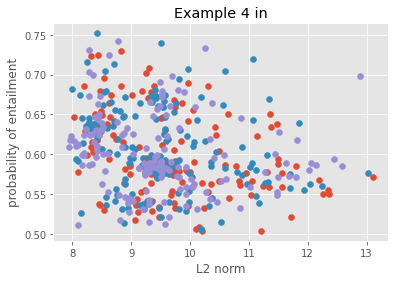

['Ġroad', '<pad>', 'Ġa', '</s>', 'ĠItaly'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['Ġroad', '<pad>', 'Ġa', '</s>', 'ĠItaly'] 



100%|██████████| 200/200 [00:58<00:00,  3.44it/s]


['Ġroad', '<pad>', 'Ġa', '</s>', 'ĠItaly'] 



100%|██████████| 200/200 [00:29<00:00,  6.79it/s]


| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: ĠItaly | attention: 0.0
Token: Ġroad | attention: 0.0
Token: Ġa | attention: 0.0


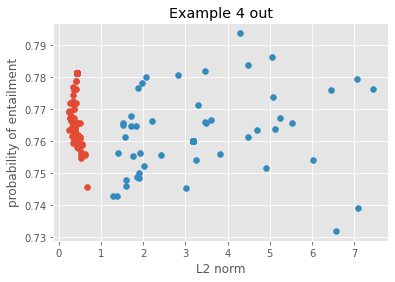

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[1], "entailment", 1, "L2",)





###### Example : 0 label contradiction ########
['</s>', 'Ġf', 'Ġbut', 'Ġyard', 'enced'] 



100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


['</s>', 'Ġf', 'Ġbut', 'Ġyard', 'enced'] 



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


['</s>', 'Ġf', 'Ġbut', 'Ġyard', 'enced'] 



100%|██████████| 200/200 [00:43<00:00,  4.57it/s]

| Min: 0.0
Token: </s> | attention: 0.0
Token: Ġyard | attention: 0.0
Token: enced | attention: 0.0
Token: Ġf | attention: 0.0
Token: Ġbut | attention: 0.0


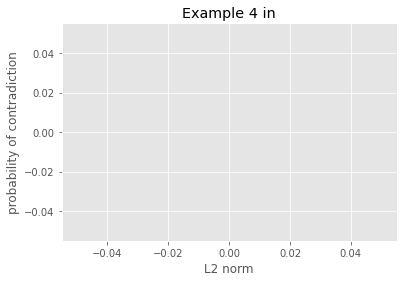

['enced', 'Ġyard', 'Ġbut', 'Ġf', '</s>'] 



100%|██████████| 200/200 [00:43<00:00,  4.60it/s]


['enced', 'Ġyard', 'Ġbut', 'Ġf', '</s>'] 



100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


['enced', 'Ġyard', 'Ġbut', 'Ġf', '</s>'] 



100%|██████████| 200/200 [00:29<00:00,  6.80it/s]


| Min: 0.0
Token: </s> | attention: 0.0
Token: Ġyard | attention: 0.0
Token: enced | attention: 0.0
Token: Ġf | attention: 0.0
Token: Ġbut | attention: 0.0


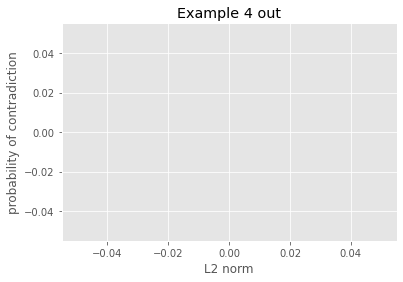





###### Example : 1 label contradiction ########
['bee', '<pad>', '</s>', 'ĠFr', 'is'] 



100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


['bee', '<pad>', '</s>', 'ĠFr', 'is'] 



100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


['bee', '<pad>', '</s>', 'ĠFr', 'is'] 



100%|██████████| 200/200 [00:46<00:00,  4.35it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: bee | attention: 0.0
Token: is | attention: 0.0
Token: ĠFr | attention: 0.0


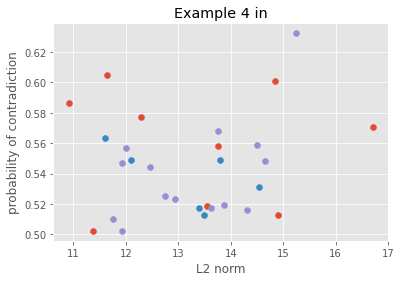

['<pad>', 'ĠFr', 'is', 'bee', '</s>'] 



100%|██████████| 200/200 [00:57<00:00,  3.45it/s]


['<pad>', 'ĠFr', 'is', 'bee', '</s>'] 



100%|██████████| 200/200 [00:57<00:00,  3.48it/s]


['<pad>', 'ĠFr', 'is', 'bee', '</s>'] 



100%|██████████| 200/200 [00:28<00:00,  6.94it/s]


| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: bee | attention: 0.0
Token: is | attention: 0.0
Token: ĠFr | attention: 0.0


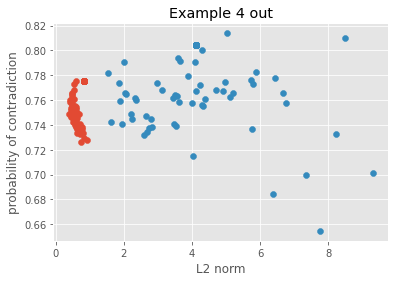





###### Example : 2 label contradiction ########
['<pad>', 'Ġvery', 'Ġlooks', 'Ġanimated', '</s>'] 



100%|██████████| 200/200 [00:53<00:00,  3.76it/s]


['<pad>', 'Ġvery', 'Ġlooks', 'Ġanimated', '</s>'] 



100%|██████████| 200/200 [00:52<00:00,  3.79it/s]


['<pad>', 'Ġvery', 'Ġlooks', 'Ġanimated', '</s>'] 



100%|██████████| 200/200 [00:51<00:00,  3.88it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġanimated | attention: 0.0
Token: Ġvery | attention: 0.0
Token: Ġlooks | attention: 0.0


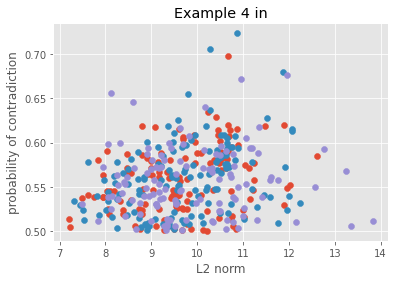

['Ġanimated', '</s>', 'Ġvery', 'Ġlooks', '<pad>'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


['Ġanimated', '</s>', 'Ġvery', 'Ġlooks', '<pad>'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


['Ġanimated', '</s>', 'Ġvery', 'Ġlooks', '<pad>'] 



100%|██████████| 200/200 [00:52<00:00,  3.79it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġanimated | attention: 0.0
Token: Ġvery | attention: 0.0
Token: Ġlooks | attention: 0.0


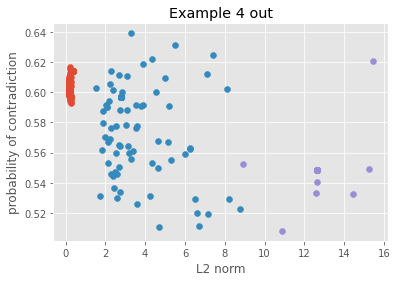

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[2], "contradiction", 2, "L2",)





###### Example : 0 label neutral ########
['</s>', 'Ġsculpture', 'Ġhair', '<pad>', 'Ġmaking'] 



100%|██████████| 200/200 [00:54<00:00,  3.69it/s]


['</s>', 'Ġsculpture', 'Ġhair', '<pad>', 'Ġmaking'] 



100%|██████████| 200/200 [00:53<00:00,  3.74it/s]


['</s>', 'Ġsculpture', 'Ġhair', '<pad>', 'Ġmaking'] 



100%|██████████| 200/200 [00:53<00:00,  3.74it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġsculpture | attention: 0.0
Token: Ġmaking | attention: 0.0
Token: Ġhair | attention: 0.0


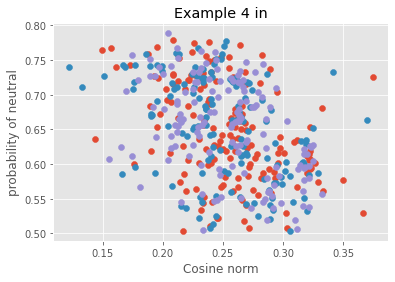

['Ġmaking', '</s>', 'Ġsculpture', '<pad>', 'Ġhair'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


['Ġmaking', '</s>', 'Ġsculpture', '<pad>', 'Ġhair'] 



100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


['Ġmaking', '</s>', 'Ġsculpture', '<pad>', 'Ġhair'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġsculpture | attention: 0.0
Token: Ġmaking | attention: 0.0
Token: Ġhair | attention: 0.0


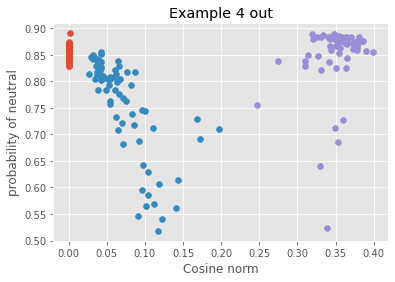





###### Example : 1 label neutral ########
['Ġat', '</s>', '<pad>', 'Ġupwards', 'Ġsomething'] 



100%|██████████| 200/200 [00:58<00:00,  3.44it/s]


['Ġat', '</s>', '<pad>', 'Ġupwards', 'Ġsomething'] 



100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


['Ġat', '</s>', '<pad>', 'Ġupwards', 'Ġsomething'] 



100%|██████████| 200/200 [00:58<00:00,  3.44it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġsomething | attention: 0.0
Token: Ġat | attention: 0.0
Token: Ġupwards | attention: 0.0


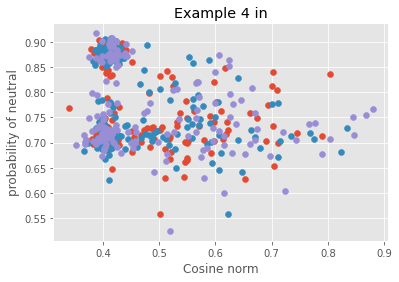

['Ġat', '<pad>', 'Ġsomething', 'Ġupwards', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.52it/s]


['Ġat', '<pad>', 'Ġsomething', 'Ġupwards', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


['Ġat', '<pad>', 'Ġsomething', 'Ġupwards', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.52it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġsomething | attention: 0.0
Token: Ġat | attention: 0.0
Token: Ġupwards | attention: 0.0


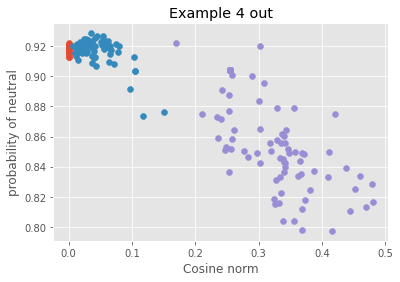





###### Example : 2 label neutral ########
['Ġpicture', 'ĠStorm', 'Ġwith', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


['Ġpicture', 'ĠStorm', 'Ġwith', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:43<00:00,  4.62it/s]


['Ġpicture', 'ĠStorm', 'Ġwith', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:43<00:00,  4.64it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: ĠStorm | attention: 0.0
Token: Ġwith | attention: 0.0
Token: Ġpicture | attention: 0.0


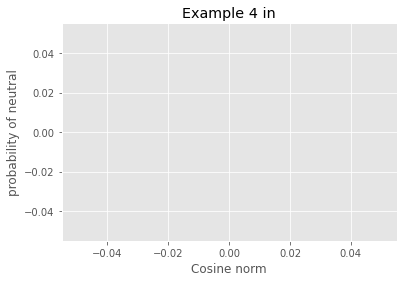

['Ġwith', '<pad>', 'ĠStorm', 'Ġpicture', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


['Ġwith', '<pad>', 'ĠStorm', 'Ġpicture', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


['Ġwith', '<pad>', 'ĠStorm', 'Ġpicture', '</s>'] 



100%|██████████| 200/200 [00:28<00:00,  7.03it/s]


| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: ĠStorm | attention: 0.0
Token: Ġwith | attention: 0.0
Token: Ġpicture | attention: 0.0


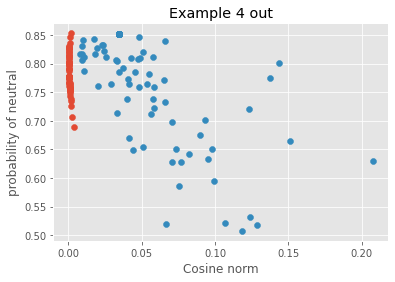

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[0], "neutral", 0, "Cosine")





###### Example : 0 label entailment ########
['</s>', 'Ġwork', 'Ġopen', 'Ġstreet', '<pad>'] 



100%|██████████| 200/200 [00:57<00:00,  3.51it/s]


['</s>', 'Ġwork', 'Ġopen', 'Ġstreet', '<pad>'] 



100%|██████████| 200/200 [00:56<00:00,  3.51it/s]


['</s>', 'Ġwork', 'Ġopen', 'Ġstreet', '<pad>'] 



100%|██████████| 200/200 [00:56<00:00,  3.52it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġwork | attention: 0.0
Token: Ġstreet | attention: 0.0
Token: Ġopen | attention: 0.0


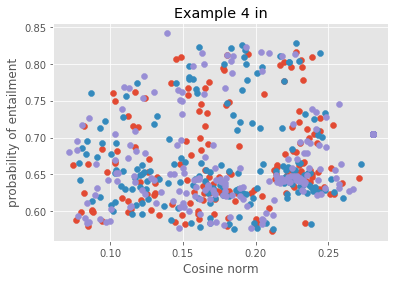

['Ġstreet', 'Ġopen', '</s>', '<pad>', 'Ġwork'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


['Ġstreet', 'Ġopen', '</s>', '<pad>', 'Ġwork'] 



100%|██████████| 200/200 [00:56<00:00,  3.52it/s]


['Ġstreet', 'Ġopen', '</s>', '<pad>', 'Ġwork'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġwork | attention: 0.0
Token: Ġstreet | attention: 0.0
Token: Ġopen | attention: 0.0


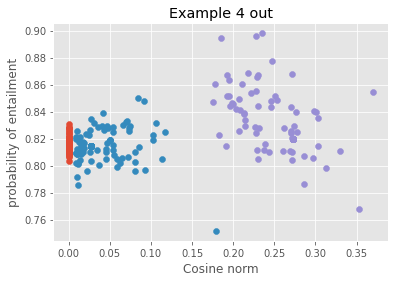





###### Example : 1 label entailment ########
['Ġan', 'Ġguitar', '<pad>', 'Ġacoustic', '</s>'] 



100%|██████████| 200/200 [00:49<00:00,  4.05it/s]


['Ġan', 'Ġguitar', '<pad>', 'Ġacoustic', '</s>'] 



100%|██████████| 200/200 [00:49<00:00,  4.02it/s]


['Ġan', 'Ġguitar', '<pad>', 'Ġacoustic', '</s>'] 



100%|██████████| 200/200 [00:48<00:00,  4.16it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġguitar | attention: 0.0
Token: Ġacoustic | attention: 0.0
Token: Ġan | attention: 0.0


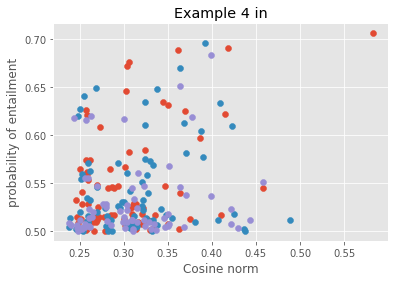

['Ġacoustic', 'Ġan', '<pad>', 'Ġguitar', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


['Ġacoustic', 'Ġan', '<pad>', 'Ġguitar', '</s>'] 



100%|██████████| 200/200 [00:46<00:00,  4.28it/s]


['Ġacoustic', 'Ġan', '<pad>', 'Ġguitar', '</s>'] 



100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġguitar | attention: 0.0
Token: Ġacoustic | attention: 0.0
Token: Ġan | attention: 0.0


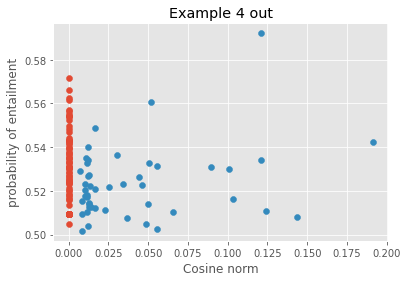





###### Example : 2 label entailment ########
['ĠItaly', 'Ġa', '</s>', '<pad>', 'Ġroad'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


['ĠItaly', 'Ġa', '</s>', '<pad>', 'Ġroad'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


['ĠItaly', 'Ġa', '</s>', '<pad>', 'Ġroad'] 



100%|██████████| 200/200 [00:56<00:00,  3.57it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: ĠItaly | attention: 0.0
Token: Ġroad | attention: 0.0
Token: Ġa | attention: 0.0


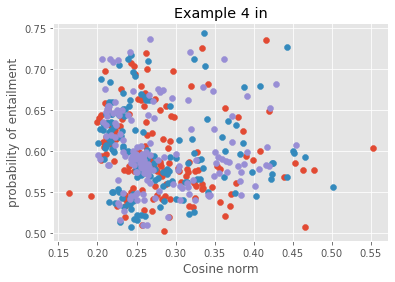

['<pad>', '</s>', 'Ġroad', 'Ġa', 'ĠItaly'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


['<pad>', '</s>', 'Ġroad', 'Ġa', 'ĠItaly'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


['<pad>', '</s>', 'Ġroad', 'Ġa', 'ĠItaly'] 



100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: ĠItaly | attention: 0.0
Token: Ġroad | attention: 0.0
Token: Ġa | attention: 0.0


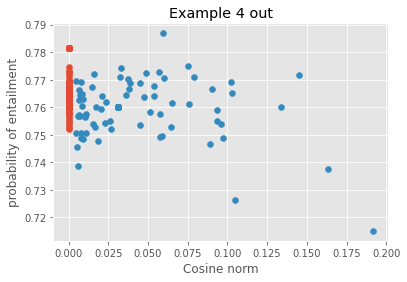

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[1], "entailment", 1, "Cosine",)





###### Example : 0 label contradiction ########
['Ġbut', 'Ġyard', '</s>', 'Ġf', 'enced'] 



100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


['Ġbut', 'Ġyard', '</s>', 'Ġf', 'enced'] 



100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


['Ġbut', 'Ġyard', '</s>', 'Ġf', 'enced'] 



100%|██████████| 200/200 [00:42<00:00,  4.68it/s]

| Min: 0.0
Token: </s> | attention: 0.0
Token: Ġyard | attention: 0.0
Token: enced | attention: 0.0
Token: Ġf | attention: 0.0
Token: Ġbut | attention: 0.0


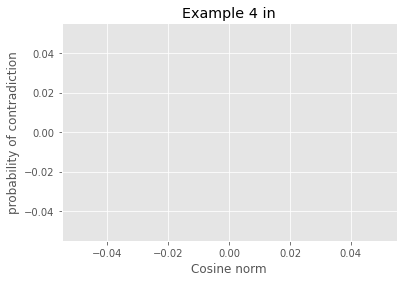

['Ġf', '</s>', 'Ġbut', 'Ġyard', 'enced'] 



100%|██████████| 200/200 [00:42<00:00,  4.68it/s]


['Ġf', '</s>', 'Ġbut', 'Ġyard', 'enced'] 



100%|██████████| 200/200 [00:42<00:00,  4.71it/s]


['Ġf', '</s>', 'Ġbut', 'Ġyard', 'enced'] 



100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


| Min: 0.0
Token: </s> | attention: 0.0
Token: Ġyard | attention: 0.0
Token: enced | attention: 0.0
Token: Ġf | attention: 0.0
Token: Ġbut | attention: 0.0


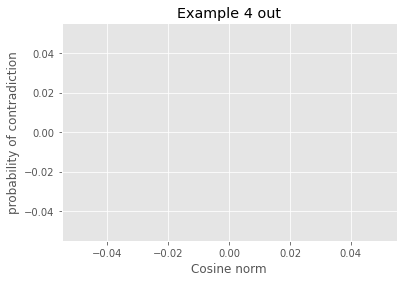





###### Example : 1 label contradiction ########
['ĠFr', 'bee', 'is', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


['ĠFr', 'bee', 'is', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.46it/s]


['ĠFr', 'bee', 'is', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: bee | attention: 0.0
Token: is | attention: 0.0
Token: ĠFr | attention: 0.0


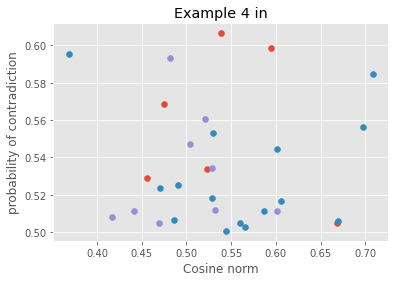

['ĠFr', '<pad>', 'bee', 'is', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


['ĠFr', '<pad>', 'bee', 'is', '</s>'] 



100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


['ĠFr', '<pad>', 'bee', 'is', '</s>'] 



100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: bee | attention: 0.0
Token: is | attention: 0.0
Token: ĠFr | attention: 0.0


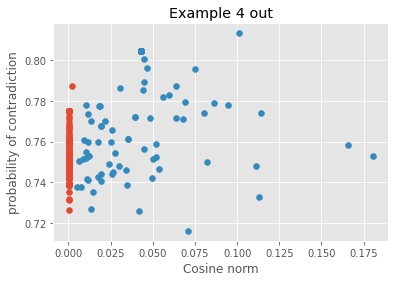





###### Example : 2 label contradiction ########
['Ġlooks', 'Ġvery', 'Ġanimated', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


['Ġlooks', 'Ġvery', 'Ġanimated', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:51<00:00,  3.86it/s]


['Ġlooks', 'Ġvery', 'Ġanimated', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:51<00:00,  3.86it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġanimated | attention: 0.0
Token: Ġvery | attention: 0.0
Token: Ġlooks | attention: 0.0


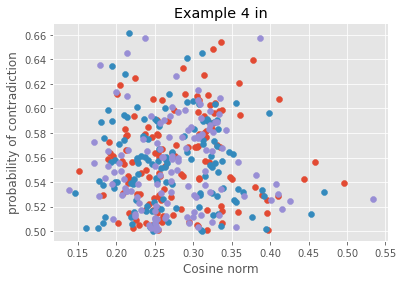

['Ġvery', '</s>', 'Ġanimated', '<pad>', 'Ġlooks'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


['Ġvery', '</s>', 'Ġanimated', '<pad>', 'Ġlooks'] 



100%|██████████| 200/200 [00:56<00:00,  3.53it/s]


['Ġvery', '</s>', 'Ġanimated', '<pad>', 'Ġlooks'] 



100%|██████████| 200/200 [00:52<00:00,  3.80it/s]

| Min: 0.0
Token: <pad> | attention: 0.0
Token: </s> | attention: 0.0
Token: Ġanimated | attention: 0.0
Token: Ġvery | attention: 0.0
Token: Ġlooks | attention: 0.0


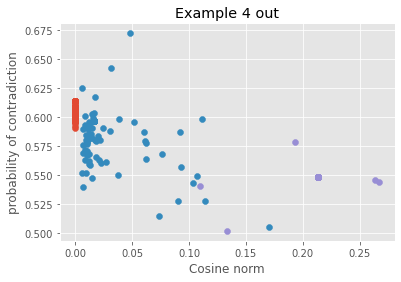

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[2], "contradiction", 2, "Cosine",)

In [ ]:
select_max_imp = 100

In [ ]:
def calculate_imp(true_logits, true_class, perturbed_logits, perturbed_class):
  if(perturbed_class == true_class):
    return true_logits[true_class] - perturbed_logits[true_class]
  return true_logits[true_class] - perturbed_logits[true_class] + true_logits[perturbed_class] - perturbed_logits[perturbed_class]

In [ ]:
print(tokenizer.decode([1532]))

 learn


In [ ]:
def intersection(a, b):
  cnt = 0;
  print(a)
  print(b)
  for i in range(min(len(a), len(b))):
      if(a[i] == b[i]):
          cnt += 1;
      
  return (cnt/min(len(a), len(b)))*100

In [ ]:
def find_intersection_top5(text_lab, label, label_ind, flag):
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i, (tokens, tokenized_threads) in enumerate(text_lab):
        print("\n\n\n")
        print("###### Example :", str(i), "label", label, "########")
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device).reshape((1, len(tokenized_threads)))
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
        
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        graph = dict()
        
        for tok in tokens:
            if(tok not in mapping_ind):
                mapping_ind[tok] = cnt;
                cnt += 1

        for lay in range(12):
            weights = attention[0, lay, :, :]
            for ind_1 in range(len(tokens)):
                for ind_2 in range(len(tokens)):
                    if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                        continue
                    node_1 = mapping_ind[tokens[ind_1]]
                    node_2 = mapping_ind[tokens[ind_2]]
                    rev_mapping_ind[node_1] = tokens[ind_1]
                    rev_mapping_ind[node_2] = tokens[ind_2]
                    weight = weights[ind_1, ind_2]
                    if(node_1 not in graph):
                        graph[node_1] = {}
                    if(node_2  not in graph[node_1]):
                        graph[node_1][node_2] = (weight, 1)
                    else:
                        graph[node_1][node_2] = ((weight + (graph[node_1][node_2][0])*graph[node_1][node_2][1])/(graph[node_1][node_2][1] + 1), graph[node_1][node_2][1] + 1)
        logits = predict_proba(tokenized_threads)
        class_assigned = torch.argmax(logits[0, :])
        topk_in, topk_out, topk_in_attention, topk_out_attention, topk_in_min, topk_out_min = find_topk_tokens(graph, select_max_imp)
        arr = tokenized_threads.cpu().detach().clone().numpy()

        candidates = []
        for j in range(len(tokens)):
          temp_tokenized_threads = np.concatenate([arr[0, : j], arr[0, j + 1:], np.array([tokenizer.pad_token_id])])
    
          temp_logits = predict_proba(torch.tensor(temp_tokenized_threads, device=device).reshape((1, len(temp_tokenized_threads))))

          temp_class_assigned = torch.argmax(temp_logits)

          importance_score = calculate_imp(logits[0], class_assigned, temp_logits[0], temp_class_assigned)
          candidates.append((arr[0, j], importance_score))
        candidates.sort(key = lambda x : x[1])
        candidates.reverse()
        print(candidates)
        print("intersection between in : ", intersection([tokenizer.decode(i[0]) for i in candidates[:select_max_imp] if tokenizer.decode(i[0]) not in ["[CLS]", "[PAD]", "[SEP]"]], [rev_mapping_ind[z] for z in topk_in]))
        print("intersection between out : ",intersection([tokenizer.decode(i[0]) for i in candidates[:select_max_imp] if tokenizer.decode(i[0]) not in ["[CLS]", "[PAD]","[SEP]"]], [rev_mapping_ind[z] for z in topk_out]))

In [ ]:

find_intersection_top5(text[2], "contradiction", 2, "Cosine",)





###### Example : 0 label contradiction ########


RuntimeError: ignored

In [ ]:
find_intersection_top5(text[1], "entailment", 1, "L2",)

In [ ]:
find_intersection_top5(text[0], "neutral", 0, "L2")

In [ ]:
def remove_padding(x):
    ret = []
    for i in x[::-1]:
        if(i == "[PAD]"):
            continue
        else:
            ret.append(i)
    ret = ret[::-1]
    return ret

In [ ]:
for i, sent in enumerate(text):
    text[i] = remove_padding(sent)


In [ ]:
color = ["\033[1;31;47m", "\033[1;32;47m", "\033[1;33;47m", 
         "\033[1;34;47m", "\033[1;35;47m", "\033[1;36;47m",
         "\033[1;37;47m"]
mapping = ["Red", "Green", "Yellow", "Blue", "Purple", "Cyan", "White"]


In [ ]:
print("\033[1;32;47m" + text[0][0])

In [ ]:
reverse_mapping = {}
for i in mapping_ind:
    reverse_mapping[mapping_ind[i]] = i

In [ ]:
tokens = []
for lay in range(12):
    for i in graph_attention[lay]:
        l = 0
        for j in graph_attention[lay][i]:
            l += graph_attention[lay][i][j][0]
        l /= len(graph_attention[lay][i])
        tokens.append((l, reverse_mapping[i]))


In [ ]:
tokens_high_deg = []
for lay in range(12):
    for i in graph_attention[lay]:
        tokens_high_deg.append((len(graph_attention[lay][i]), reverse_mapping[i]))

In [ ]:
tokens.sort(reverse = True)
tokens_high_deg.sort(reverse = True)

In [ ]:
print(tokens[:10])
print(tokens_high_deg[:10])

In [ ]:
factor = 40
factor_2 = 20

In [ ]:
Truetop_tok = [i[1] for i in tokens[:len(mapping)*factor]]
top_tok_deg = [i[1] for i in tokens_high_deg[:len(mapping)*factor_2]]


In [ ]:
def parse_top_k(l, length):
    ret = []
    ind = 0
    mapping_check = {}
    while(len(ret) != length and ind < len(l)):
        if(l[ind][1] in mapping_check):
            ind += 1
            continue
        mapping_check[l[ind][1]] = 1
        ret.append(l[ind][1])
        ind += 1
    return ret
top_tok = parse_top_k(tokens, len(mapping)*factor)

top_tok_deg = parse_top_k(tokens_high_deg, len(mapping)*factor_2)

In [ ]:
print("Attention")
print(top_tok)
print("Degree ")
print(top_tok_deg)

In [ ]:
print(len(top_tok_deg))

In [ ]:
print(set(top_tok))


In [ ]:
print(set(top_tok_deg))

In [ ]:
def masking_text(tok, text, color):
    for i in range(len(text)):
        print("\t ###################### Example " + str(i) + " ##############")
        print("")
        masked_text = []
        for j in text[i]:
            flag = 0
            for ind in range(len(tok)):
                if(j == tok[ind]):
                    masked_text.append(color[ind//factor] + j + "\x1b[0m")
                    flag = 1
                    break
            if(flag == 0):
                masked_text.append(j)
        print(" ".join(masked_text))   
        
        print("")

In [ ]:
print("\t ####### Mapping for high attention value \n \n")
for i in range(len(mapping)):
    print(color[i], mapping[i], " : ", top_tok[i*factor : (i + 1)*factor])

In [ ]:
for i in range(len(mapping)):
    print(mapping[i], " : ", "(attention value) priority top : ", str(i*factor), "-", str((i + 1)*factor))

In [ ]:
print(masking_text(top_tok, text, color))

In [ ]:
print("\t ####### Mapping for Degree value \n \n")
for i in range(len(mapping)):
    print(color[i] ,mapping[i], " : ", top_tok_deg[i*factor_2 : (i + 1)*factor_2])

In [ ]:
for i in range(len(mapping)):
    print(mapping[i], " : ", "(degree) priority top : ", str(i*factor), "-", str((i + 1)*factor_2))

In [ ]:
print(masking_text(top_tok_deg, text, color))

In [ ]:
print(set(i[1] for i in tokens[:100]))

In [ ]:
print(set(i[1] for i in tokens_high_deg[:200]))

In [ ]:
import matplotlib.pyplot as plt

def plot_degree_dist(degrees):
    plt.hist(degrees)
    plt.show()


In [ ]:
for lay in range(12):
    degree = []
    for i in graph_attention[lay]:
        degree.append(len(graph_attention[lay][i]))
    degree.sort(reverse = True)
    plot_degree_dist(degree)
    